# 1. BTC/USD Dataset (Data split 7:3)

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
#import data
path = "../Dataset/BTC_USD-Binance-Historical-Data_New.csv"
data_btc = pd.read_csv(path, index_col='Date', parse_dates=True)
data_btc

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"67,768.50","67,564.80","67,868.20","67,470.70",8.84K,0.33%
2024-05-31,"67,548.00","68,366.40","69,010.00","66,692.00",26.69K,-1.18%
2024-05-30,"68,352.20","67,652.70","69,500.00","67,141.80",28.48K,1.03%
2024-05-29,"67,652.40","68,425.10","68,914.00","67,150.00",23.16K,-1.06%
2024-05-28,"68,374.00","69,420.00","69,570.00","67,294.30",32.62K,-1.54%
...,...,...,...,...,...,...
2019-03-05,"3,857.50","3,716.10","3,876.00","3,705.40",30.82K,3.83%
2019-03-04,"3,715.00","3,807.80","3,828.00","3,674.90",32.61K,-2.40%
2019-03-03,"3,806.40","3,820.30","3,834.70","3,784.80",15.99K,-0.36%


In [4]:
#preprocessing data
data_btc = data_btc.sort_index(ascending=True)
data_btc['Price'] = data_btc['Price'].replace(',', '', regex=True).astype(float)
data_btc.dropna(inplace=True)  
data_btc

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,3823.2,"3,813.60","3,856.30","3,813.40",22.28K,0.24%
2019-03-02,3820.0,"3,820.50","3,840.40","3,775.00",18.49K,-0.08%
2019-03-03,3806.4,"3,820.30","3,834.70","3,784.80",15.99K,-0.36%
2019-03-04,3715.0,"3,807.80","3,828.00","3,674.90",32.61K,-2.40%
2019-03-05,3857.5,"3,716.10","3,876.00","3,705.40",30.82K,3.83%
...,...,...,...,...,...,...
2024-05-28,68374.0,"69,420.00","69,570.00","67,294.30",32.62K,-1.54%
2024-05-29,67652.4,"68,425.10","68,914.00","67,150.00",23.16K,-1.06%
2024-05-30,68352.2,"67,652.70","69,500.00","67,141.80",28.48K,1.03%


In [5]:
price_btc = data_btc['Price'].values
price_btc = price_btc.reshape(-1, 1)
price_btc

array([[ 3823.2],
       [ 3820. ],
       [ 3806.4],
       ...,
       [68352.2],
       [67548. ],
       [67768.5]])

In [6]:
# Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
price_btc_scaled = scaler.fit_transform(price_btc)

In [7]:
train_size = int(len(price_btc_scaled) * 0.7)
test_size = int(len(price_btc_scaled)) - train_size

train_data_btc = price_btc_scaled[:train_size]
test_data_btc = price_btc_scaled[train_size:]


In [8]:
#Tạo các đặc trưng chuỗi thời gian sử dụng kỹ thuật time_step
def create_time_series_features(data, time_steps = 1):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i+time_steps), 0])
        y.append(data[i+time_steps,0])
    return np.array(X), np.array(y)

time_steps = 30
btc_X_train, btc_y_train = create_time_series_features(train_data_btc, time_steps)
btc_X_test, btc_y_test = create_time_series_features(test_data_btc, time_steps)

btc_X_train = btc_X_train.reshape(btc_X_train.shape[0], btc_X_train.shape[1])
btc_X_test = btc_X_test.reshape(btc_X_test.shape[0], btc_X_train.shape[1])

In [9]:
# Tìm kiếm siêu tham số tốt nhất
# grid_rf = {
#     'n_estimators': [20, 50, 100, 200],
#     'max_depth': np.arange(1, 15, 1),
#     'min_samples_split': [2, 10, 9],
#     'min_samples_leaf': np.arange(1, 15, 2, dtype=int),
#     'bootstrap': [True, False],
#     'random_state': [1, 2, 30, 42]
# }

# model = RandomForestRegressor()
# rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=2, n_jobs=-1, verbose=2, n_iter=200)
# rscv_fit = rscv.fit(X_train, y_train)
# best_parameters = rscv_fit.best_params_

# print("Best Parameters:", best_parameters)

In [10]:
# Huấn luyện mô hình với siêu tham số tốt nhất
# model = RandomForestRegressor(**best_parameters)
btc_model = RandomForestRegressor(random_state=42, n_estimators=20)
btc_model.fit(btc_X_train, btc_y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [11]:
# Dự báo
btc_test_predict = btc_model.predict(btc_X_test)
btc_test_predict = btc_test_predict.reshape(-1, 1)
btc_test_predict = scaler.inverse_transform(btc_test_predict)
btc_y_test = scaler.inverse_transform([btc_y_test])
btc_test_predict

array([[17903.535],
       [17903.535],
       [17903.535],
       [17885.7  ],
       [17882.075],
       [17885.7  ],
       [17883.87 ],
       [17887.495],
       [17908.99 ],
       [17889.325],
       [18304.87 ],
       [18724.545],
       [17940.955],
       [17880.02 ],
       [17880.02 ],
       [17883.87 ],
       [17883.87 ],
       [17883.87 ],
       [17883.87 ],
       [17913.43 ],
       [17913.43 ],
       [17928.335],
       [17928.335],
       [17920.755],
       [17920.755],
       [17883.87 ],
       [17880.245],
       [17883.87 ],
       [17883.87 ],
       [17883.87 ],
       [17879.745],
       [17879.745],
       [17885.7  ],
       [17883.87 ],
       [17887.495],
       [17883.87 ],
       [17887.495],
       [17883.87 ],
       [18098.21 ],
       [18706.66 ],
       [18693.815],
       [18939.915],
       [21647.535],
       [21592.755],
       [22522.045],
       [22522.045],
       [20659.26 ],
       [22416.49 ],
       [24432.29 ],
       [24604.77 ],


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Đánh giá hiệu suất của mô hình
mape = np.mean(np.abs((btc_y_test.flatten() - btc_test_predict.flatten()) / btc_y_test.flatten())) * 100
rmse = np.sqrt(mean_squared_error(btc_y_test.flatten(), btc_test_predict.flatten()))
mae = mean_absolute_error(btc_y_test.flatten(), btc_test_predict.flatten())

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 2195.81
MAPE: 4.43
MAE: 1580.86


In [14]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = data_btc['Price'].values[-30:]
next_30_days = []

for i in range(30):
    x = last_30_days[-time_steps:].reshape(1, time_steps)
    y_hat = btc_model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

[[64192.52 ]
 [64192.52 ]
 [64293.67 ]
 [64293.67 ]
 [64192.52 ]
 [64192.52 ]
 [64268.005]
 [64191.865]
 [64293.9  ]
 [64395.05 ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]]


In [15]:
# Dự báo giá trị 60 ngày trong tương lai
last_60_days = data_btc['Price'].values[-60:]
next_60_days = []

for i in range(60):
    x = last_60_days[-time_steps:].reshape(1, time_steps)
    y_hat = btc_model.predict(x)
    next_60_days.append(y_hat)
    last_60_days = np.append(last_60_days, y_hat)

next_60_days = np.array(next_60_days).reshape(-1, 1)
next_60_days = scaler.inverse_transform(next_60_days)

print(next_60_days)

[[64192.52 ]
 [64192.52 ]
 [64293.67 ]
 [64293.67 ]
 [64192.52 ]
 [64192.52 ]
 [64268.005]
 [64191.865]
 [64293.9  ]
 [64395.05 ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]]


In [16]:
# Dự báo giá trị 90 ngày trong tương lai
last_90_days = data_btc['Price'].values[-90:]
next_90_days = []

for i in range(90):
    x = last_90_days[-time_steps:].reshape(1, time_steps)
    y_hat = btc_model.predict(x)
    next_90_days.append(y_hat)
    last_90_days = np.append(last_90_days, y_hat)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print(next_90_days)

[[64192.52 ]
 [64192.52 ]
 [64293.67 ]
 [64293.67 ]
 [64192.52 ]
 [64192.52 ]
 [64268.005]
 [64191.865]
 [64293.9  ]
 [64395.05 ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]
 [64293.9  ]

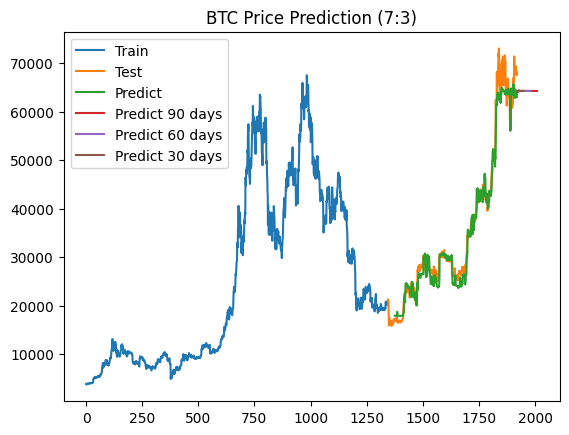

In [17]:
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data_btc), label="Train")

# test
test_data_index = pd.RangeIndex(start=len(data_btc) - len(test_data_btc), stop=len(data_btc), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data_btc), label="Test")

test_data_index = pd.RangeIndex(start=train_size+31, stop=len(data_btc), step=1)
plt.plot(test_data_index, btc_test_predict.squeeze(), label="Predict", linestyle="-")

#90 days
predict_data_index = pd.RangeIndex(start=len(data_btc), stop=len(data_btc) + 90, step=1)
plt.plot(predict_data_index, next_90_days.squeeze(), label="Predict 90 days")

#60 days
predict_data_index = pd.RangeIndex(start=len(data_btc), stop=len(data_btc) + 60, step=1)
plt.plot(predict_data_index, next_60_days.squeeze(), label="Predict 60 days")

#30 days
predict_data_index = pd.RangeIndex(start=len(data_btc), stop=len(data_btc) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="Predict 30 days")

plt.legend()
plt.title('BTC Price Prediction (7:3)')
plt.show()

# 2. ETH/USD Dataset (Data split 7:3)

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [19]:
#import data
path = "../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"3,815.93","3,765.83","3,832.37","3,753.29",132.67K,1.42%
2024-05-31,"3,762.59","3,748.31","3,845.00","3,724.51",273.40K,0.39%
2024-05-30,"3,747.91","3,767.15","3,824.91","3,703.70",277.03K,-0.58%
2024-05-29,"3,769.65","3,847.76","3,886.39","3,745.70",334.76K,-1.97%
2024-05-28,"3,845.56","3,894.21","3,929.20","3,775.00",416.24K,-1.25%
...,...,...,...,...,...,...
2019-03-05,136.59,125.75,137.86,125.14,1.04M,8.61%
2019-03-04,125.76,130.44,130.95,122.85,943.18K,-3.59%
2019-03-03,130.45,132.54,134.58,128.65,786.86K,-1.58%


In [20]:
#preprocessing data
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)  
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,135.31,135.36,137.88,135,803.72K,-0.02%
2019-03-02,132.54,135.32,135.98,130.32,869.32K,-2.05%
2019-03-03,130.45,132.54,134.58,128.65,786.86K,-1.58%
2019-03-04,125.76,130.44,130.95,122.85,943.18K,-3.59%
2019-03-05,136.59,125.75,137.86,125.14,1.04M,8.61%
...,...,...,...,...,...,...
2024-05-28,3845.56,"3,894.21","3,929.20","3,775.00",416.24K,-1.25%
2024-05-29,3769.65,"3,847.76","3,886.39","3,745.70",334.76K,-1.97%
2024-05-30,3747.91,"3,767.15","3,824.91","3,703.70",277.03K,-0.58%


In [21]:
price = data['Price'].values
price = price.reshape(-1, 1)
price

array([[ 135.31],
       [ 132.54],
       [ 130.45],
       ...,
       [3747.91],
       [3762.59],
       [3815.93]])

In [22]:
# Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [23]:
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled)) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

In [24]:
def create_time_series_features(data, time_steps = 1):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i+time_steps), 0])
        y.append(data[i+time_steps,0])
    return np.array(X), np.array(y)

time_steps = 30
X_train, y_train = create_time_series_features(train_data, time_steps)
X_test, y_test = create_time_series_features(test_data, time_steps)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1])
X_train, y_train

(array([[0.00589936, 0.00531006, 0.00486543, ..., 0.00644185, 0.00756301,
         0.00725666],
        [0.00531006, 0.00486543, 0.00386767, ..., 0.00756301, 0.00725666,
         0.00719496],
        [0.00486543, 0.00386767, 0.00617167, ..., 0.00725666, 0.00719496,
         0.00716518],
        ...,
        [0.25618497, 0.24847091, 0.25865704, ..., 0.30780064, 0.32167361,
         0.31547002],
        [0.24847091, 0.25865704, 0.26676254, ..., 0.32167361, 0.31547002,
         0.31172788],
        [0.25865704, 0.26676254, 0.26475212, ..., 0.31547002, 0.31172788,
         0.31316815]]),
 array([0.00719496, 0.00716518, 0.01187956, ..., 0.31172788, 0.31316815,
        0.30028656]))

In [25]:
# # Tìm kiếm siêu tham số tốt nhất
# grid_rf = {
#     'n_estimators': [20, 50, 100, 200],
#     'max_depth': np.arange(1, 15, 1),
#     'min_samples_split': [2, 10, 9],
#     'min_samples_leaf': np.arange(1, 15, 2, dtype=int),
#     'bootstrap': [True, False],
#     'random_state': [1, 2, 30, 42]
# }

# model = RandomForestRegressor()
# rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=2, n_jobs=-1, verbose=2, n_iter=200)
# rscv_fit = rscv.fit(btc_X_train, btc_y_train)
# best_parameters = rscv_fit.best_params_

# print("Best Parameters:", best_parameters)

In [26]:
# Huấn luyện mô hình với siêu tham số tốt nhất
# model = RandomForestRegressor(**best_parameters)
model = RandomForestRegressor(random_state=42, n_estimators=20)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [27]:
test_predict = model.predict(X_test)
test_predict = test_predict.reshape(-1, 1)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
test_predict

array([[1321.157 ],
       [1345.633 ],
       [1305.0395],
       [1339.751 ],
       [1251.9775],
       [1333.524 ],
       [1313.3565],
       [1333.1175],
       [1307.033 ],
       [1334.707 ],
       [1350.747 ],
       [1345.35  ],
       [1329.4755],
       [1162.883 ],
       [1203.653 ],
       [1205.298 ],
       [1164.7105],
       [1227.67  ],
       [1216.6765],
       [1207.9705],
       [1208.8385],
       [1200.724 ],
       [1195.633 ],
       [1204.012 ],
       [1179.825 ],
       [1185.7705],
       [1177.2705],
       [1176.2175],
       [1199.9625],
       [1199.754 ],
       [1199.869 ],
       [1198.0515],
       [1306.0985],
       [1309.122 ],
       [1330.473 ],
       [1299.8295],
       [1331.139 ],
       [1338.3805],
       [1348.9365],
       [1362.8905],
       [1466.326 ],
       [1518.899 ],
       [1556.52  ],
       [1552.5995],
       [1570.843 ],
       [1564.953 ],
       [1564.147 ],
       [1592.799 ],
       [1632.844 ],
       [1654.169 ],


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Đánh giá hiệu suất của mô hình
mape = np.mean(np.abs((y_test.flatten() - test_predict.flatten()) / y_test.flatten())) * 100
rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predict.flatten()))
mae = mean_absolute_error(y_test.flatten(), test_predict.flatten())

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 83.18
MAPE: 2.58
MAE: 56.61


In [29]:
def predict_future_days(model, last_days, days_to_predict, scaler, time_step):
    predictions = []
    last_data = last_days.copy()

    for _ in range(days_to_predict):
        x = last_data[-time_step:].reshape(1, -1)
        y_hat = model.predict(x)
        predictions.append(y_hat[0])
        last_data = np.append(last_data, y_hat)
        
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    return predictions

# Dự báo cho 30, 60 và 90 ngày
last_days = price_scaled[-time_steps:]
next_30_days = predict_future_days(model, last_days, 30, scaler, time_steps)
next_60_days = predict_future_days(model, last_days, 60, scaler, time_steps)
next_90_days = predict_future_days(model, last_days, 90, scaler, time_steps)


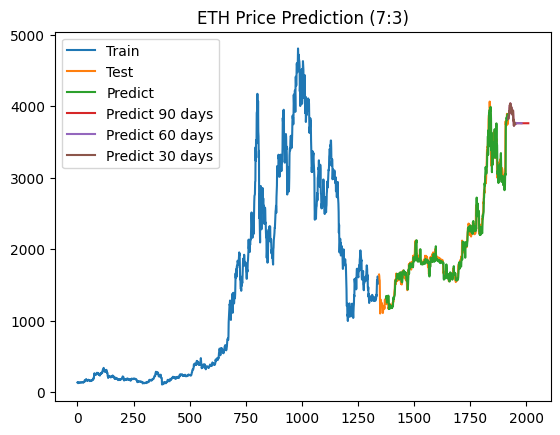

In [30]:
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size + 31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#90 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 90, step=1)
plt.plot(predict_data_index, next_90_days.squeeze(), label="Predict 90 days")

#60 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 60, step=1)
plt.plot(predict_data_index, next_60_days.squeeze(), label="Predict 60 days")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="Predict 30 days")

plt.legend()
plt.title('ETH Price Prediction (7:3)')
plt.show()

# 3. BNB/USD Dataset (Data split 7:3)

In [31]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [32]:
path = "../Dataset/BNB_USD-Binance-Historical-Data_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,601.80,594.00,608.20,593.20,156.40K,1.35%
2024-05-31,593.80,595.00,598.90,590.10,168.61K,-0.20%
2024-05-30,595.00,595.70,601.80,586.60,225.46K,-0.10%
2024-05-29,595.60,601.90,603.60,593.30,212.71K,-1.01%
2024-05-28,601.70,603.80,605.50,594.30,284.87K,-0.35%
...,...,...,...,...,...,...
2019-03-05,13.65,11.40,13.74,11.40,8.34M,19.61%
2019-03-04,11.41,11.45,11.51,10.88,2.74M,-0.29%
2019-03-03,11.45,11.74,11.86,11.20,2.86M,-2.58%


In [33]:
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)  
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,11.35,10.27,11.55,10.24,4.02M,10.45%
2019-03-02,11.75,11.33,11.80,10.83,3.89M,3.56%
2019-03-03,11.45,11.74,11.86,11.20,2.86M,-2.58%
2019-03-04,11.41,11.45,11.51,10.88,2.74M,-0.29%
2019-03-05,13.65,11.40,13.74,11.40,8.34M,19.61%
...,...,...,...,...,...,...
2024-05-28,601.70,603.80,605.50,594.30,284.87K,-0.35%
2024-05-29,595.60,601.90,603.60,593.30,212.71K,-1.01%
2024-05-30,595.00,595.70,601.80,586.60,225.46K,-0.10%


In [34]:
price = data['Price'].values
price = price.reshape(-1, 1)
price

array([[ 11.35],
       [ 11.75],
       [ 11.45],
       ...,
       [595.  ],
       [593.8 ],
       [601.8 ]])

In [35]:
# Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [36]:
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled)) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

In [37]:
def create_time_series_features(data, time_steps = 1):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i+time_steps), 0])
        y.append(data[i+time_steps,0])
    return np.array(X), np.array(y)

time_steps = 30
X_train, y_train = create_time_series_features(train_data, time_steps)
X_test, y_test = create_time_series_features(test_data, time_steps)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1])
X_train, y_train

(array([[0.00310419, 0.00370404, 0.00325415, ..., 0.01105213, 0.01081219,
         0.011532  ],
        [0.00370404, 0.00325415, 0.00319417, ..., 0.01081219, 0.011532  ,
         0.01237178],
        [0.00325415, 0.00319417, 0.0065533 , ..., 0.011532  , 0.01237178,
         0.01294164],
        ...,
        [0.41032332, 0.41257273, 0.41647172, ..., 0.43266751, 0.44256493,
         0.45621139],
        [0.41257273, 0.41647172, 0.43041809, ..., 0.44256493, 0.45621139,
         0.47465659],
        [0.41647172, 0.43041809, 0.42711895, ..., 0.45621139, 0.47465659,
         0.47180733]]),
 array([0.01237178, 0.01294164, 0.01565593, ..., 0.47465659, 0.47180733,
        0.46625877]))

In [38]:
# Tìm kiếm siêu tham số tốt nhất
# grid_rf = {
#     'n_estimators': [20, 50, 100, 200],
#     'max_depth': np.arange(1, 15, 1),
#     'min_samples_split': [2, 10, 9],
#     'min_samples_leaf': np.arange(1, 15, 2, dtype=int),
#     'bootstrap': [True, False],
#     'random_state': [1, 2, 30, 42]
# }

# model = RandomForestRegressor()
# rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=2, n_jobs=-1, verbose=2, n_iter=200)
# rscv_fit = rscv.fit(btc_X_train, btc_y_train)
# best_parameters = rscv_fit.best_params_

# print("Best Parameters:", best_parameters)

In [39]:
# Huấn luyện mô hình với siêu tham số tốt nhất
# model = RandomForestRegressor(**best_parameters)
model = RandomForestRegressor(random_state=42, n_estimators=20)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [40]:
test_predict = model.predict(X_test)
test_predict = test_predict.reshape(-1, 1)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
test_predict

array([[290.2165],
       [293.4325],
       [289.6905],
       [288.7235],
       [285.595 ],
       [285.264 ],
       [284.6   ],
       [288.515 ],
       [285.175 ],
       [274.7355],
       [267.545 ],
       [271.107 ],
       [269.397 ],
       [243.7185],
       [250.268 ],
       [252.3445],
       [243.6915],
       [249.583 ],
       [243.5385],
       [245.574 ],
       [245.851 ],
       [238.86  ],
       [244.489 ],
       [245.792 ],
       [248.8095],
       [248.5945],
       [250.5765],
       [248.979 ],
       [248.865 ],
       [250.459 ],
       [246.414 ],
       [248.659 ],
       [265.8395],
       [261.397 ],
       [267.0225],
       [265.2615],
       [277.952 ],
       [279.7535],
       [281.262 ],
       [285.8065],
       [282.883 ],
       [282.973 ],
       [304.3795],
       [316.3295],
       [306.3115],
       [300.9725],
       [291.082 ],
       [286.736 ],
       [301.768 ],
       [305.595 ],
       [306.2695],
       [313.099 ],
       [308.

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Đánh giá hiệu suất của mô hình
mape = np.mean(np.abs((y_test.flatten() - test_predict.flatten()) / y_test.flatten())) * 100
rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predict.flatten()))
mae = mean_absolute_error(y_test.flatten(), test_predict.flatten())

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 13.16
MAPE: 2.96
MAE: 9.20


In [42]:
def predict_future_days(model, last_days, days_to_predict, scaler, time_step):
    predictions = []
    last_data = last_days.copy()

    for _ in range(days_to_predict):
        x = last_data[-time_step:].reshape(1, -1)
        y_hat = model.predict(x)
        predictions.append(y_hat[0])
        last_data = np.append(last_data, y_hat)
        
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    return predictions

# Dự báo cho 30, 60 và 90 ngày
last_days = price_scaled[-time_steps:]
next_30_days = predict_future_days(model, last_days, 30, scaler, time_steps)
next_60_days = predict_future_days(model, last_days, 60, scaler, time_steps)
next_90_days = predict_future_days(model, last_days, 90, scaler, time_steps)

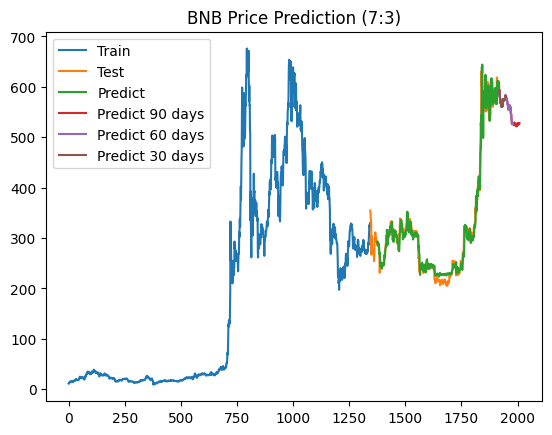

In [43]:
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size + 31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#90 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 90, step=1)
plt.plot(predict_data_index, next_90_days.squeeze(), label="Predict 90 days")

#60 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 60, step=1)
plt.plot(predict_data_index, next_60_days.squeeze(), label="Predict 60 days")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="Predict 30 days")

plt.legend()
plt.title('BNB Price Prediction (7:3)')
plt.show()

# 4. BTC/USD Dataset (Data split 8:2)

In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [45]:
path = "../Dataset/BTC_USD-Binance-Historical-Data_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"67,768.50","67,564.80","67,868.20","67,470.70",8.84K,0.33%
2024-05-31,"67,548.00","68,366.40","69,010.00","66,692.00",26.69K,-1.18%
2024-05-30,"68,352.20","67,652.70","69,500.00","67,141.80",28.48K,1.03%
2024-05-29,"67,652.40","68,425.10","68,914.00","67,150.00",23.16K,-1.06%
2024-05-28,"68,374.00","69,420.00","69,570.00","67,294.30",32.62K,-1.54%
...,...,...,...,...,...,...
2019-03-05,"3,857.50","3,716.10","3,876.00","3,705.40",30.82K,3.83%
2019-03-04,"3,715.00","3,807.80","3,828.00","3,674.90",32.61K,-2.40%
2019-03-03,"3,806.40","3,820.30","3,834.70","3,784.80",15.99K,-0.36%


In [46]:
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)  
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,3823.2,"3,813.60","3,856.30","3,813.40",22.28K,0.24%
2019-03-02,3820.0,"3,820.50","3,840.40","3,775.00",18.49K,-0.08%
2019-03-03,3806.4,"3,820.30","3,834.70","3,784.80",15.99K,-0.36%
2019-03-04,3715.0,"3,807.80","3,828.00","3,674.90",32.61K,-2.40%
2019-03-05,3857.5,"3,716.10","3,876.00","3,705.40",30.82K,3.83%
...,...,...,...,...,...,...
2024-05-28,68374.0,"69,420.00","69,570.00","67,294.30",32.62K,-1.54%
2024-05-29,67652.4,"68,425.10","68,914.00","67,150.00",23.16K,-1.06%
2024-05-30,68352.2,"67,652.70","69,500.00","67,141.80",28.48K,1.03%


In [47]:
price = data['Price'].values
price = price.reshape(-1, 1)
price

array([[ 3823.2],
       [ 3820. ],
       [ 3806.4],
       ...,
       [68352.2],
       [67548. ],
       [67768.5]])

In [48]:
# Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [49]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled)) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

In [50]:
#Tạo các đặc trưng chuỗi thời gian sử dụng kỹ thuật time_step
def create_time_series_features(data, time_steps = 1):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i+time_steps), 0])
        y.append(data[i+time_steps,0])
    return np.array(X), np.array(y)

time_steps = 30
X_train, y_train = create_time_series_features(train_data, time_steps)
X_test, y_test = create_time_series_features(test_data, time_steps)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1])
X_train, y_train

(array([[0.0015603 , 0.00151415, 0.00131803, ..., 0.00451073, 0.00558217,
         0.00564706],
        [0.00151415, 0.00131803, 0.        , ..., 0.00558217, 0.00564706,
         0.00559515],
        [0.00131803, 0.        , 0.00205492, ..., 0.00564706, 0.00559515,
         0.00620369],
        ...,
        [0.38198132, 0.37731773, 0.38453374, ..., 0.3453778 , 0.34487597,
         0.34441596],
        [0.37731773, 0.38453374, 0.38578832, ..., 0.34487597, 0.34441596,
         0.33548535],
        [0.38453374, 0.38578832, 0.38329791, ..., 0.34441596, 0.33548535,
         0.33283775]]),
 array([0.00559515, 0.00620369, 0.01651145, ..., 0.33548535, 0.33283775,
        0.33254069]))

In [51]:
# # Tìm kiếm siêu tham số tốt nhất
# grid_rf = {
#     'n_estimators': [20, 50, 100, 200],
#     'max_depth': np.arange(1, 15, 1),
#     'min_samples_split': [2, 10, 9],
#     'min_samples_leaf': np.arange(1, 15, 2, dtype=int),
#     'bootstrap': [True, False],
#     'random_state': [1, 2, 30, 42]
# }

# model = RandomForestRegressor()
# rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=2, n_jobs=-1, verbose=2, n_iter=200)
# rscv_fit = rscv.fit(btc_X_train, btc_y_train)
# best_parameters = rscv_fit.best_params_

# print("Best Parameters:", best_parameters)

In [52]:
# Huấn luyện mô hình với siêu tham số tốt nhất
# model = RandomForestRegressor(**best_parameters)
model = RandomForestRegressor(random_state=42, n_estimators=20)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [53]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = test_predict.reshape(-1, 1)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
test_predict

array([[25317.38 ],
       [25390.77 ],
       [25472.72 ],
       [25446.995],
       [25470.08 ],
       [25556.635],
       [27415.915],
       [28133.91 ],
       [30473.065],
       [30316.99 ],
       [30340.255],
       [30310.495],
       [30130.83 ],
       [30062.14 ],
       [29959.   ],
       [29979.01 ],
       [29648.37 ],
       [29840.435],
       [29759.79 ],
       [29807.465],
       [30133.34 ],
       [29958.925],
       [29954.41 ],
       [30170.225],
       [29681.045],
       [30005.345],
       [30176.375],
       [29769.91 ],
       [29952.195],
       [29844.86 ],
       [30665.83 ],
       [29770.115],
       [29816.39 ],
       [29742.64 ],
       [29744.235],
       [29972.7  ],
       [30202.535],
       [29884.835],
       [29865.115],
       [29953.005],
       [29994.545],
       [29023.   ],
       [29183.9  ],
       [29906.125],
       [29066.375],
       [29560.16 ],
       [29877.08 ],
       [29645.205],
       [28881.02 ],
       [29796.815],


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Đánh giá hiệu suất của mô hình
mape = np.mean(np.abs((y_test.flatten() - test_predict.flatten()) / y_test.flatten())) * 100
rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predict.flatten()))
mae = mean_absolute_error(y_test.flatten(), test_predict.flatten())

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 2383.56
MAPE: 2.99
MAE: 1490.35


In [55]:
def predict_future_days(model, last_days, days_to_predict, scaler, time_step):
    predictions = []
    last_data = last_days.copy()

    for _ in range(days_to_predict):
        x = last_data[-time_step:].reshape(1, -1)
        y_hat = model.predict(x)
        predictions.append(y_hat[0])
        last_data = np.append(last_data, y_hat)
        
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    return predictions

# Dự báo cho 30, 60 và 90 ngày
last_days = price_scaled[-time_steps:]
next_30_days = predict_future_days(model, last_days, 30, scaler, time_steps)
next_60_days = predict_future_days(model, last_days, 60, scaler, time_steps)
next_90_days = predict_future_days(model, last_days, 90, scaler, time_steps)

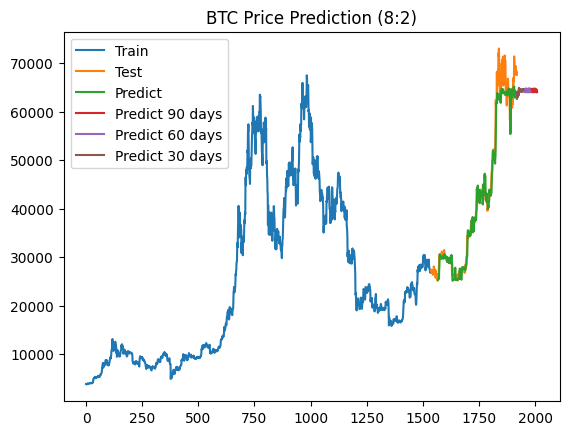

In [56]:
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size + 31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#90 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 90, step=1)
plt.plot(predict_data_index, next_90_days.squeeze(), label="Predict 90 days")

#60 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 60, step=1)
plt.plot(predict_data_index, next_60_days.squeeze(), label="Predict 60 days")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="Predict 30 days")

plt.legend()
plt.title('BTC Price Prediction (8:2)')
plt.show()

# 5. ETH/USD Dataset (Data split 8:2)

In [57]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [58]:
#import data
path = "../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"3,815.93","3,765.83","3,832.37","3,753.29",132.67K,1.42%
2024-05-31,"3,762.59","3,748.31","3,845.00","3,724.51",273.40K,0.39%
2024-05-30,"3,747.91","3,767.15","3,824.91","3,703.70",277.03K,-0.58%
2024-05-29,"3,769.65","3,847.76","3,886.39","3,745.70",334.76K,-1.97%
2024-05-28,"3,845.56","3,894.21","3,929.20","3,775.00",416.24K,-1.25%
...,...,...,...,...,...,...
2019-03-05,136.59,125.75,137.86,125.14,1.04M,8.61%
2019-03-04,125.76,130.44,130.95,122.85,943.18K,-3.59%
2019-03-03,130.45,132.54,134.58,128.65,786.86K,-1.58%


In [59]:
#preprocessing data
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)  
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,135.31,135.36,137.88,135,803.72K,-0.02%
2019-03-02,132.54,135.32,135.98,130.32,869.32K,-2.05%
2019-03-03,130.45,132.54,134.58,128.65,786.86K,-1.58%
2019-03-04,125.76,130.44,130.95,122.85,943.18K,-3.59%
2019-03-05,136.59,125.75,137.86,125.14,1.04M,8.61%
...,...,...,...,...,...,...
2024-05-28,3845.56,"3,894.21","3,929.20","3,775.00",416.24K,-1.25%
2024-05-29,3769.65,"3,847.76","3,886.39","3,745.70",334.76K,-1.97%
2024-05-30,3747.91,"3,767.15","3,824.91","3,703.70",277.03K,-0.58%


In [60]:
price = data['Price'].values
price = price.reshape(-1, 1)
price

array([[ 135.31],
       [ 132.54],
       [ 130.45],
       ...,
       [3747.91],
       [3762.59],
       [3815.93]])

In [61]:
# Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [62]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled)) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

In [63]:
#Tạo các đặc trưng chuỗi thời gian sử dụng kỹ thuật time_step
def create_time_series_features(data, time_steps = 1):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i+time_steps), 0])
        y.append(data[i+time_steps,0])
    return np.array(X), np.array(y)

time_steps = 30
X_train, y_train = create_time_series_features(train_data, time_steps)
X_test, y_test = create_time_series_features(test_data, time_steps)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1])
X_train, y_train

(array([[0.00589936, 0.00531006, 0.00486543, ..., 0.00644185, 0.00756301,
         0.00725666],
        [0.00531006, 0.00486543, 0.00386767, ..., 0.00756301, 0.00725666,
         0.00719496],
        [0.00486543, 0.00386767, 0.00617167, ..., 0.00725666, 0.00719496,
         0.00716518],
        ...,
        [0.37916949, 0.38484547, 0.40518157, ..., 0.37014494, 0.36994922,
         0.36874722],
        [0.38484547, 0.40518157, 0.42387103, ..., 0.36994922, 0.36874722,
         0.35891637],
        [0.40518157, 0.42387103, 0.4218755 , ..., 0.36874722, 0.35891637,
         0.36159906]]),
 array([0.00719496, 0.00716518, 0.01187956, ..., 0.35891637, 0.36159906,
        0.35900998]))

In [64]:
# # Tìm kiếm siêu tham số tốt nhất
# grid_rf = {
#     'n_estimators': [20, 50, 100, 200],
#     'max_depth': np.arange(1, 15, 1),
#     'min_samples_split': [2, 10, 9],
#     'min_samples_leaf': np.arange(1, 15, 2, dtype=int),
#     'bootstrap': [True, False],
#     'random_state': [1, 2, 30, 42]
# }

# model = RandomForestRegressor()
# rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=2, n_jobs=-1, verbose=2, n_iter=200)
# rscv_fit = rscv.fit(btc_X_train, btc_y_train)
# best_parameters = rscv_fit.best_params_

# print("Best Parameters:", best_parameters)

In [65]:
# Huấn luyện mô hình với siêu tham số tốt nhất
# model = RandomForestRegressor(**best_parameters)
model = RandomForestRegressor(random_state=42, n_estimators=20)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [66]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = test_predict.reshape(-1, 1)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
test_predict

array([[1815.2295],
       [1645.8595],
       [1595.2995],
       [1727.289 ],
       [1792.18  ],
       [1747.903 ],
       [1811.5215],
       [1819.3035],
       [1890.991 ],
       [1877.159 ],
       [1893.231 ],
       [1877.897 ],
       [1868.2285],
       [1853.9995],
       [1885.3685],
       [1840.1745],
       [1851.7945],
       [1885.425 ],
       [1894.491 ],
       [1886.4495],
       [1965.2435],
       [1884.627 ],
       [1893.617 ],
       [1866.224 ],
       [1887.712 ],
       [1877.597 ],
       [1879.5585],
       [1892.628 ],
       [1894.9205],
       [1898.058 ],
       [2029.954 ],
       [1906.0365],
       [1903.9615],
       [1902.862 ],
       [1895.3395],
       [1883.292 ],
       [1882.172 ],
       [1883.0665],
       [1886.601 ],
       [1860.205 ],
       [1886.8045],
       [1862.982 ],
       [1863.9225],
       [1876.5715],
       [1868.173 ],
       [1872.0305],
       [1874.738 ],
       [1854.689 ],
       [1864.3665],
       [1886.9445],


In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Đánh giá hiệu suất của mô hình
mape = np.mean(np.abs((y_test.flatten() - test_predict.flatten()) / y_test.flatten())) * 100
rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predict.flatten()))
mae = mean_absolute_error(y_test.flatten(), test_predict.flatten())

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 91.51
MAPE: 2.40
MAE: 60.34


In [68]:
def predict_future_days(model, last_days, days_to_predict, scaler, time_step):
    predictions = []
    last_data = last_days.copy()

    for _ in range(days_to_predict):
        x = last_data[-time_step:].reshape(1, -1)
        y_hat = model.predict(x)
        predictions.append(y_hat[0])
        last_data = np.append(last_data, y_hat)
        
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    return predictions

# Dự báo cho 30, 60 và 90 ngày
last_days = price_scaled[-time_steps:]
next_30_days = predict_future_days(model, last_days, 30, scaler, time_steps)
next_60_days = predict_future_days(model, last_days, 60, scaler, time_steps)
next_90_days = predict_future_days(model, last_days, 90, scaler, time_steps)


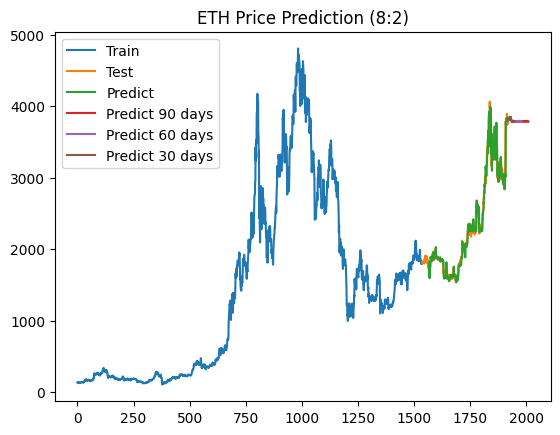

In [69]:
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size + 31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#90 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 90, step=1)
plt.plot(predict_data_index, next_90_days.squeeze(), label="Predict 90 days")

#60 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 60, step=1)
plt.plot(predict_data_index, next_60_days.squeeze(), label="Predict 60 days")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="Predict 30 days")

plt.legend()
plt.title('ETH Price Prediction (8:2)')
plt.show()

# 6. BNB/USD Dataset (Data split 8:2)

In [70]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [71]:
#import data
path = "../Dataset/BNB_USD-Binance-Historical-Data_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,601.80,594.00,608.20,593.20,156.40K,1.35%
2024-05-31,593.80,595.00,598.90,590.10,168.61K,-0.20%
2024-05-30,595.00,595.70,601.80,586.60,225.46K,-0.10%
2024-05-29,595.60,601.90,603.60,593.30,212.71K,-1.01%
2024-05-28,601.70,603.80,605.50,594.30,284.87K,-0.35%
...,...,...,...,...,...,...
2019-03-05,13.65,11.40,13.74,11.40,8.34M,19.61%
2019-03-04,11.41,11.45,11.51,10.88,2.74M,-0.29%
2019-03-03,11.45,11.74,11.86,11.20,2.86M,-2.58%


In [72]:
#preprocessing data
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)  
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,11.35,10.27,11.55,10.24,4.02M,10.45%
2019-03-02,11.75,11.33,11.80,10.83,3.89M,3.56%
2019-03-03,11.45,11.74,11.86,11.20,2.86M,-2.58%
2019-03-04,11.41,11.45,11.51,10.88,2.74M,-0.29%
2019-03-05,13.65,11.40,13.74,11.40,8.34M,19.61%
...,...,...,...,...,...,...
2024-05-28,601.70,603.80,605.50,594.30,284.87K,-0.35%
2024-05-29,595.60,601.90,603.60,593.30,212.71K,-1.01%
2024-05-30,595.00,595.70,601.80,586.60,225.46K,-0.10%


In [73]:
price = data['Price'].values
price = price.reshape(-1, 1)
price

array([[ 11.35],
       [ 11.75],
       [ 11.45],
       ...,
       [595.  ],
       [593.8 ],
       [601.8 ]])

In [74]:
# Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [75]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled)) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

In [76]:
#Tạo các đặc trưng chuỗi thời gian sử dụng kỹ thuật time_step
def create_time_series_features(data, time_steps = 1):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i+time_steps), 0])
        y.append(data[i+time_steps,0])
    return np.array(X), np.array(y)

time_steps = 30
X_train, y_train = create_time_series_features(train_data, time_steps)
X_test, y_test = create_time_series_features(test_data, time_steps)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1])
X_train, y_train

(array([[0.00310419, 0.00370404, 0.00325415, ..., 0.01105213, 0.01081219,
         0.011532  ],
        [0.00370404, 0.00325415, 0.00319417, ..., 0.01081219, 0.011532  ,
         0.01237178],
        [0.00325415, 0.00319417, 0.0065533 , ..., 0.011532  , 0.01237178,
         0.01294164],
        ...,
        [0.46925799, 0.46565893, 0.47285706, ..., 0.45666127, 0.45426189,
         0.45741107],
        [0.46565893, 0.47285706, 0.47915542, ..., 0.45426189, 0.45741107,
         0.44721372],
        [0.47285706, 0.47915542, 0.48545378, ..., 0.45741107, 0.44721372,
         0.4488633 ]]),
 array([0.01237178, 0.01294164, 0.01565593, ..., 0.44721372, 0.4488633 ,
        0.45201248]))

In [77]:
# Tìm kiếm siêu tham số tốt nhất
# grid_rf = {
#     'n_estimators': [20, 50, 100, 200],
#     'max_depth': np.arange(1, 15, 1),
#     'min_samples_split': [2, 10, 9],
#     'min_samples_leaf': np.arange(1, 15, 2, dtype=int),
#     'bootstrap': [True, False],
#     'random_state': [1, 2, 30, 42]
# }

# model = RandomForestRegressor()
# rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=2, n_jobs=-1, verbose=2, n_iter=200)
# rscv_fit = rscv.fit(X_train, y_train)
# best_parameters = rscv_fit.best_params_

# print("Best Parameters:", best_parameters)

In [78]:
# Huấn luyện mô hình với siêu tham số tốt nhất
# model = RandomForestRegressor(**best_parameters)
model = RandomForestRegressor(random_state=42, n_estimators=20)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [79]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = test_predict.reshape(-1, 1)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
test_predict

array([[248.84  ],
       [249.152 ],
       [243.2385],
       [249.1055],
       [249.2455],
       [248.6375],
       [249.01  ],
       [245.55  ],
       [250.39  ],
       [244.1595],
       [243.4295],
       [239.55  ],
       [245.708 ],
       [240.5555],
       [244.3805],
       [234.125 ],
       [233.675 ],
       [249.35  ],
       [248.885 ],
       [250.11  ],
       [252.084 ],
       [251.7305],
       [245.9145],
       [233.7605],
       [237.991 ],
       [243.6845],
       [244.6195],
       [250.935 ],
       [251.4885],
       [253.875 ],
       [257.984 ],
       [250.393 ],
       [254.1515],
       [251.027 ],
       [250.895 ],
       [252.198 ],
       [252.3345],
       [249.3145],
       [249.8345],
       [252.566 ],
       [253.0725],
       [250.534 ],
       [247.707 ],
       [250.2615],
       [250.8655],
       [249.65  ],
       [250.5945],
       [253.6845],
       [250.8115],
       [248.7015],
       [247.195 ],
       [247.1615],
       [248.

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Đánh giá hiệu suất của mô hình
mape = np.mean(np.abs((y_test.flatten() - test_predict.flatten()) / y_test.flatten())) * 100
rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predict.flatten()))
mae = mean_absolute_error(y_test.flatten(), test_predict.flatten())

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 15.06
MAPE: 3.37
MAE: 10.62


In [81]:
def predict_future_days(model, last_days, days_to_predict, scaler, time_step):
    predictions = []
    last_data = last_days.copy()

    for _ in range(days_to_predict):
        x = last_data[-time_step:].reshape(1, -1)
        y_hat = model.predict(x)
        predictions.append(y_hat[0])
        last_data = np.append(last_data, y_hat)
        
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    return predictions

# Dự báo cho 30, 60 và 90 ngày
last_days = price_scaled[-time_steps:]
next_30_days = predict_future_days(model, last_days, 30, scaler, time_steps)
next_60_days = predict_future_days(model, last_days, 60, scaler, time_steps)
next_90_days = predict_future_days(model, last_days, 90, scaler, time_steps)

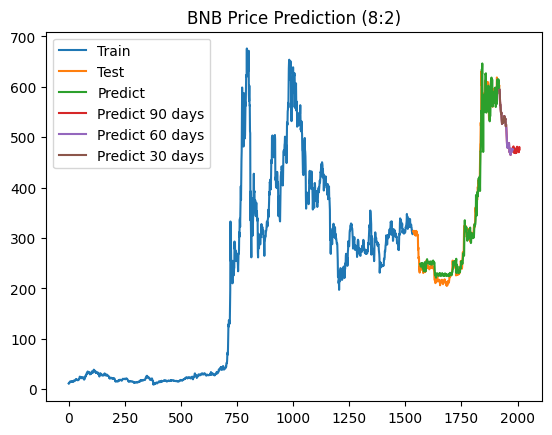

In [82]:
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size + 31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#90 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 90, step=1)
plt.plot(predict_data_index, next_90_days.squeeze(), label="Predict 90 days")

#60 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 60, step=1)
plt.plot(predict_data_index, next_60_days.squeeze(), label="Predict 60 days")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="Predict 30 days")

plt.legend()
plt.title('BNB Price Prediction (8:2)')
plt.show()

# 7. BTC/USD Dataset (Data split 9:1)

In [83]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [84]:
path = "../Dataset/BTC_USD-Binance-Historical-Data_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"67,768.50","67,564.80","67,868.20","67,470.70",8.84K,0.33%
2024-05-31,"67,548.00","68,366.40","69,010.00","66,692.00",26.69K,-1.18%
2024-05-30,"68,352.20","67,652.70","69,500.00","67,141.80",28.48K,1.03%
2024-05-29,"67,652.40","68,425.10","68,914.00","67,150.00",23.16K,-1.06%
2024-05-28,"68,374.00","69,420.00","69,570.00","67,294.30",32.62K,-1.54%
...,...,...,...,...,...,...
2019-03-05,"3,857.50","3,716.10","3,876.00","3,705.40",30.82K,3.83%
2019-03-04,"3,715.00","3,807.80","3,828.00","3,674.90",32.61K,-2.40%
2019-03-03,"3,806.40","3,820.30","3,834.70","3,784.80",15.99K,-0.36%


In [85]:
#preprocessing data
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)  
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,3823.2,"3,813.60","3,856.30","3,813.40",22.28K,0.24%
2019-03-02,3820.0,"3,820.50","3,840.40","3,775.00",18.49K,-0.08%
2019-03-03,3806.4,"3,820.30","3,834.70","3,784.80",15.99K,-0.36%
2019-03-04,3715.0,"3,807.80","3,828.00","3,674.90",32.61K,-2.40%
2019-03-05,3857.5,"3,716.10","3,876.00","3,705.40",30.82K,3.83%
...,...,...,...,...,...,...
2024-05-28,68374.0,"69,420.00","69,570.00","67,294.30",32.62K,-1.54%
2024-05-29,67652.4,"68,425.10","68,914.00","67,150.00",23.16K,-1.06%
2024-05-30,68352.2,"67,652.70","69,500.00","67,141.80",28.48K,1.03%


In [86]:
price = data['Price'].values
price = price.reshape(-1, 1)
price

array([[ 3823.2],
       [ 3820. ],
       [ 3806.4],
       ...,
       [68352.2],
       [67548. ],
       [67768.5]])

In [87]:
# Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [88]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled)) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

In [89]:
def create_time_series_features(data, time_steps = 1):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i+time_steps), 0])
        y.append(data[i+time_steps,0])
    return np.array(X), np.array(y)

time_steps = 30
X_train, y_train = create_time_series_features(train_data, time_steps)
X_test, y_test = create_time_series_features(test_data, time_steps)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1])
X_train, y_train

(array([[0.0015603 , 0.00151415, 0.00131803, ..., 0.00451073, 0.00558217,
         0.00564706],
        [0.00151415, 0.00131803, 0.        , ..., 0.00558217, 0.00564706,
         0.00559515],
        [0.00131803, 0.        , 0.00205492, ..., 0.00564706, 0.00559515,
         0.00620369],
        ...,
        [0.37426924, 0.37774169, 0.37877564, ..., 0.46788126, 0.47413109,
         0.47369848],
        [0.37774169, 0.37877564, 0.4226889 , ..., 0.47413109, 0.47369848,
         0.48502144],
        [0.37877564, 0.4226889 , 0.43555774, ..., 0.47369848, 0.48502144,
         0.48640869]]),
 array([0.00559515, 0.00620369, 0.01651145, ..., 0.48502144, 0.48640869,
        0.46270863]))

In [90]:
# Tìm kiếm siêu tham số tốt nhất
# grid_rf = {
#     'n_estimators': [20, 50, 100, 200],
#     'max_depth': np.arange(1, 15, 1),
#     'min_samples_split': [2, 10, 9],
#     'min_samples_leaf': np.arange(1, 15, 2, dtype=int),
#     'bootstrap': [True, False],
#     'random_state': [1, 2, 30, 42]
# }

# model = RandomForestRegressor()
# rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=2, n_jobs=-1, verbose=2, n_iter=200)
# rscv_fit = rscv.fit(X_train, y_train)
# best_parameters = rscv_fit.best_params_

# print("Best Parameters:", best_parameters)

In [91]:
# Huấn luyện mô hình với siêu tham số tốt nhất
# model = RandomForestRegressor(**best_parameters)
model = RandomForestRegressor(random_state=42, n_estimators=20)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [92]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = test_predict.reshape(-1, 1)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
test_predict

array([[43854.72 ],
       [42918.02 ],
       [43035.02 ],
       [43029.725],
       [42733.12 ],
       [42947.76 ],
       [43057.91 ],
       [40744.205],
       [40760.435],
       [41326.345],
       [44099.43 ],
       [45021.715],
       [42315.4  ],
       [43681.555],
       [43305.725],
       [43454.035],
       [43255.79 ],
       [46890.965],
       [45199.58 ],
       [45979.53 ],
       [45208.295],
       [42479.615],
       [42545.56 ],
       [41466.06 ],
       [42974.375],
       [43348.635],
       [42778.94 ],
       [41148.455],
       [41307.58 ],
       [41219.92 ],
       [41550.685],
       [39856.35 ],
       [40163.9  ],
       [40442.605],
       [40440.655],
       [41568.54 ],
       [41542.04 ],
       [41504.595],
       [43794.335],
       [43324.17 ],
       [42408.6  ],
       [42911.33 ],
       [42918.585],
       [42803.52 ],
       [42667.95 ],
       [42618.52 ],
       [43223.205],
       [43629.875],
       [45024.715],
       [46916.65 ],


In [93]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Đánh giá hiệu suất của mô hình
mape = np.mean(np.abs((y_test.flatten() - test_predict.flatten()) / y_test.flatten())) * 100
rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predict.flatten()))
mae = mean_absolute_error(y_test.flatten(), test_predict.flatten())

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 3483.36
MAPE: 4.01
MAE: 2515.80


In [94]:
def predict_future_days(model, last_days, days_to_predict, scaler, time_step):
    predictions = []
    last_data = last_days.copy()

    for _ in range(days_to_predict):
        x = last_data[-time_step:].reshape(1, -1)
        y_hat = model.predict(x)
        predictions.append(y_hat[0])
        last_data = np.append(last_data, y_hat)
        
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    return predictions

# Dự báo cho 30, 60 và 90 ngày
last_days = price_scaled[-time_steps:]
next_30_days = predict_future_days(model, last_days, 30, scaler, time_steps)
next_60_days = predict_future_days(model, last_days, 60, scaler, time_steps)
next_90_days = predict_future_days(model, last_days, 90, scaler, time_steps)

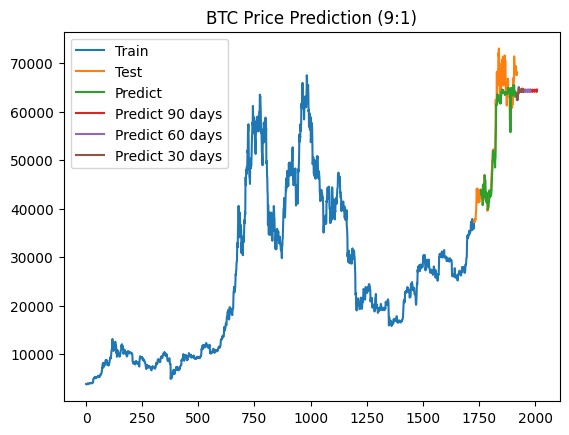

In [95]:
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size + 31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#90 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 90, step=1)
plt.plot(predict_data_index, next_90_days.squeeze(), label="Predict 90 days")

#60 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 60, step=1)
plt.plot(predict_data_index, next_60_days.squeeze(), label="Predict 60 days")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="Predict 30 days")

plt.legend()
plt.title('BTC Price Prediction (9:1)')
plt.show()

# 8. ETH/USD Dataset (Data split 9:1)

In [96]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [97]:
path = "../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"3,815.93","3,765.83","3,832.37","3,753.29",132.67K,1.42%
2024-05-31,"3,762.59","3,748.31","3,845.00","3,724.51",273.40K,0.39%
2024-05-30,"3,747.91","3,767.15","3,824.91","3,703.70",277.03K,-0.58%
2024-05-29,"3,769.65","3,847.76","3,886.39","3,745.70",334.76K,-1.97%
2024-05-28,"3,845.56","3,894.21","3,929.20","3,775.00",416.24K,-1.25%
...,...,...,...,...,...,...
2019-03-05,136.59,125.75,137.86,125.14,1.04M,8.61%
2019-03-04,125.76,130.44,130.95,122.85,943.18K,-3.59%
2019-03-03,130.45,132.54,134.58,128.65,786.86K,-1.58%


In [98]:
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)  
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,135.31,135.36,137.88,135,803.72K,-0.02%
2019-03-02,132.54,135.32,135.98,130.32,869.32K,-2.05%
2019-03-03,130.45,132.54,134.58,128.65,786.86K,-1.58%
2019-03-04,125.76,130.44,130.95,122.85,943.18K,-3.59%
2019-03-05,136.59,125.75,137.86,125.14,1.04M,8.61%
...,...,...,...,...,...,...
2024-05-28,3845.56,"3,894.21","3,929.20","3,775.00",416.24K,-1.25%
2024-05-29,3769.65,"3,847.76","3,886.39","3,745.70",334.76K,-1.97%
2024-05-30,3747.91,"3,767.15","3,824.91","3,703.70",277.03K,-0.58%


In [99]:
price = data['Price'].values
price = price.reshape(-1, 1)
price

array([[ 135.31],
       [ 132.54],
       [ 130.45],
       ...,
       [3747.91],
       [3762.59],
       [3815.93]])

In [100]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [101]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled)) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

In [102]:
def create_time_series_features(data, time_steps = 1):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i+time_steps), 0])
        y.append(data[i+time_steps,0])
    return np.array(X), np.array(y)

time_steps = 30
X_train, y_train = create_time_series_features(train_data, time_steps)
X_test, y_test = create_time_series_features(test_data, time_steps)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1])
X_train, y_train

(array([[0.00589936, 0.00531006, 0.00486543, ..., 0.00644185, 0.00756301,
         0.00725666],
        [0.00531006, 0.00486543, 0.00386767, ..., 0.00756301, 0.00725666,
         0.00719496],
        [0.00486543, 0.00386767, 0.00617167, ..., 0.00725666, 0.00719496,
         0.00716518],
        ...,
        [0.31832929, 0.3236585 , 0.33098536, ..., 0.39446571, 0.39425509,
         0.39444656],
        [0.3236585 , 0.33098536, 0.35229794, ..., 0.39425509, 0.39444656,
         0.40493691],
        [0.33098536, 0.35229794, 0.35682086, ..., 0.39444656, 0.40493691,
         0.40716858]]),
 array([0.00719496, 0.00716518, 0.01187956, ..., 0.40493691, 0.40716858,
        0.38868761]))

In [103]:
# Tìm kiếm siêu tham số tốt nhất
# grid_rf = {
#     'n_estimators': [20, 50, 100, 200],
#     'max_depth': np.arange(1, 15, 1),
#     'min_samples_split': [2, 10, 9],
#     'min_samples_leaf': np.arange(1, 15, 2, dtype=int),
#     'bootstrap': [True, False],
#     'random_state': [1, 2, 30, 42]
# }

# model = RandomForestRegressor()
# rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=2, n_jobs=-1, verbose=2, n_iter=200)
# rscv_fit = rscv.fit(btc_X_train, btc_y_train)
# best_parameters = rscv_fit.best_params_

# print("Best Parameters:", best_parameters)

In [104]:
# Huấn luyện mô hình với siêu tham số tốt nhất
# model = RandomForestRegressor(**best_parameters)
model = RandomForestRegressor(random_state=42, n_estimators=20)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [105]:
test_predict = model.predict(X_test)
test_predict = test_predict.reshape(-1, 1)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
test_predict

array([[2310.3105],
       [2295.9535],
       [2259.9195],
       [2257.6425],
       [2256.283 ],
       [2456.4595],
       [2296.0715],
       [2292.7765],
       [2271.931 ],
       [2269.8505],
       [2326.942 ],
       [2330.359 ],
       [2274.4195],
       [2269.3655],
       [2272.952 ],
       [2256.7955],
       [2301.9125],
       [2296.4405],
       [2284.6615],
       [2526.0725],
       [2708.428 ],
       [2514.922 ],
       [2531.8775],
       [2553.513 ],
       [2570.1595],
       [2582.065 ],
       [2544.5435],
       [2559.5005],
       [2570.017 ],
       [2557.008 ],
       [2558.288 ],
       [2291.452 ],
       [2230.355 ],
       [2228.709 ],
       [2270.078 ],
       [2236.2775],
       [2264.183 ],
       [2256.459 ],
       [2288.7605],
       [2305.2195],
       [2287.86  ],
       [2301.8555],
       [2262.2325],
       [2245.252 ],
       [2213.054 ],
       [2227.381 ],
       [2407.6305],
       [2508.7505],
       [2465.329 ],
       [2512.4385],


In [106]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Đánh giá hiệu suất của mô hình
mape = np.mean(np.abs((y_test.flatten() - test_predict.flatten()) / y_test.flatten())) * 100
rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predict.flatten()))
mae = mean_absolute_error(y_test.flatten(), test_predict.flatten())

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 123.61
MAPE: 2.84
MAE: 87.73


In [107]:
def predict_future_days(model, last_days, days_to_predict, scaler, time_step):
    predictions = []
    last_data = last_days.copy()

    for _ in range(days_to_predict):
        x = last_data[-time_step:].reshape(1, -1)
        y_hat = model.predict(x)
        predictions.append(y_hat[0])
        last_data = np.append(last_data, y_hat)
        
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    return predictions

# Dự báo cho 30, 60 và 90 ngày
last_days = price_scaled[-time_steps:]
next_30_days = predict_future_days(model, last_days, 30, scaler, time_steps)
next_60_days = predict_future_days(model, last_days, 60, scaler, time_steps)
next_90_days = predict_future_days(model, last_days, 90, scaler, time_steps)

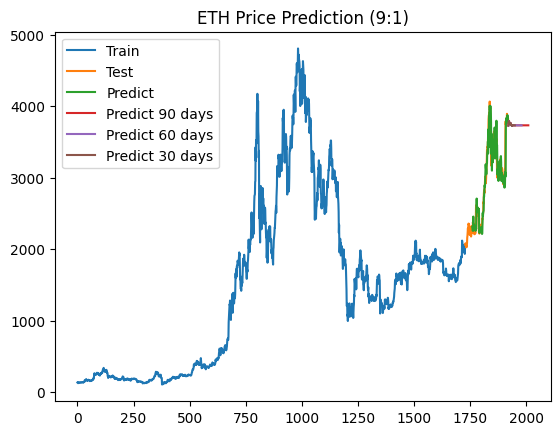

In [108]:
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size + 31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#90 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 90, step=1)
plt.plot(predict_data_index, next_90_days.squeeze(), label="Predict 90 days")

#60 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 60, step=1)
plt.plot(predict_data_index, next_60_days.squeeze(), label="Predict 60 days")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="Predict 30 days")

plt.legend()
plt.title('ETH Price Prediction (9:1)')
plt.show()

# 9. BNB/USD Dataset (Data split 9:1)

In [109]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [110]:
#import data
path = "../Dataset/BNB_USD-Binance-Historical-Data_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,601.80,594.00,608.20,593.20,156.40K,1.35%
2024-05-31,593.80,595.00,598.90,590.10,168.61K,-0.20%
2024-05-30,595.00,595.70,601.80,586.60,225.46K,-0.10%
2024-05-29,595.60,601.90,603.60,593.30,212.71K,-1.01%
2024-05-28,601.70,603.80,605.50,594.30,284.87K,-0.35%
...,...,...,...,...,...,...
2019-03-05,13.65,11.40,13.74,11.40,8.34M,19.61%
2019-03-04,11.41,11.45,11.51,10.88,2.74M,-0.29%
2019-03-03,11.45,11.74,11.86,11.20,2.86M,-2.58%


In [111]:
#preprocessing data
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)  
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,11.35,10.27,11.55,10.24,4.02M,10.45%
2019-03-02,11.75,11.33,11.80,10.83,3.89M,3.56%
2019-03-03,11.45,11.74,11.86,11.20,2.86M,-2.58%
2019-03-04,11.41,11.45,11.51,10.88,2.74M,-0.29%
2019-03-05,13.65,11.40,13.74,11.40,8.34M,19.61%
...,...,...,...,...,...,...
2024-05-28,601.70,603.80,605.50,594.30,284.87K,-0.35%
2024-05-29,595.60,601.90,603.60,593.30,212.71K,-1.01%
2024-05-30,595.00,595.70,601.80,586.60,225.46K,-0.10%


In [112]:
price = data['Price'].values
price = price.reshape(-1, 1)
price

array([[ 11.35],
       [ 11.75],
       [ 11.45],
       ...,
       [595.  ],
       [593.8 ],
       [601.8 ]])

In [113]:
# Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [114]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled)) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

In [115]:
def create_time_series_features(data, time_steps = 1):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i+time_steps), 0])
        y.append(data[i+time_steps,0])
    return np.array(X), np.array(y)

time_steps = 30
X_train, y_train = create_time_series_features(train_data, time_steps)
X_test, y_test = create_time_series_features(test_data, time_steps)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1])
X_train, y_train

(array([[0.00310419, 0.00370404, 0.00325415, ..., 0.01105213, 0.01081219,
         0.011532  ],
        [0.00370404, 0.00325415, 0.00319417, ..., 0.01081219, 0.011532  ,
         0.01237178],
        [0.00325415, 0.00319417, 0.0065533 , ..., 0.011532  , 0.01237178,
         0.01294164],
        ...,
        [0.46925799, 0.46565893, 0.47285706, ..., 0.45666127, 0.45426189,
         0.45741107],
        [0.46565893, 0.47285706, 0.47915542, ..., 0.45426189, 0.45741107,
         0.44721372],
        [0.47285706, 0.47915542, 0.48545378, ..., 0.45741107, 0.44721372,
         0.4488633 ]]),
 array([0.01237178, 0.01294164, 0.01565593, ..., 0.44721372, 0.4488633 ,
        0.45201248]))

In [116]:
# Tìm kiếm siêu tham số tốt nhất
# grid_rf = {
#     'n_estimators': [20, 50, 100, 200],
#     'max_depth': np.arange(1, 15, 1),
#     'min_samples_split': [2, 10, 9],
#     'min_samples_leaf': np.arange(1, 15, 2, dtype=int),
#     'bootstrap': [True, False],
#     'random_state': [1, 2, 30, 42]
# }

# model = RandomForestRegressor()
# rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=2, n_jobs=-1, verbose=2, n_iter=200)
# rscv_fit = rscv.fit(btc_X_train, btc_y_train)
# best_parameters = rscv_fit.best_params_

# print("Best Parameters:", best_parameters)

In [117]:
# Huấn luyện mô hình với siêu tham số tốt nhất
# model = RandomForestRegressor(**best_parameters)
model = RandomForestRegressor(random_state=42, n_estimators=20)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [118]:
test_predict = model.predict(X_test)
test_predict = test_predict.reshape(-1, 1)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
test_predict

array([[248.84  ],
       [249.152 ],
       [243.2385],
       [249.1055],
       [249.2455],
       [248.6375],
       [249.01  ],
       [245.55  ],
       [250.39  ],
       [244.1595],
       [243.4295],
       [239.55  ],
       [245.708 ],
       [240.5555],
       [244.3805],
       [234.125 ],
       [233.675 ],
       [249.35  ],
       [248.885 ],
       [250.11  ],
       [252.084 ],
       [251.7305],
       [245.9145],
       [233.7605],
       [237.991 ],
       [243.6845],
       [244.6195],
       [250.935 ],
       [251.4885],
       [253.875 ],
       [257.984 ],
       [250.393 ],
       [254.1515],
       [251.027 ],
       [250.895 ],
       [252.198 ],
       [252.3345],
       [249.3145],
       [249.8345],
       [252.566 ],
       [253.0725],
       [250.534 ],
       [247.707 ],
       [250.2615],
       [250.8655],
       [249.65  ],
       [250.5945],
       [253.6845],
       [250.8115],
       [248.7015],
       [247.195 ],
       [247.1615],
       [248.

In [119]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Đánh giá hiệu suất của mô hình
mape = np.mean(np.abs((y_test.flatten() - test_predict.flatten()) / y_test.flatten())) * 100
rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predict.flatten()))
mae = mean_absolute_error(y_test.flatten(), test_predict.flatten())

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 15.06
MAPE: 3.37
MAE: 10.62


In [120]:
def predict_future_days(model, last_days, days_to_predict, scaler, time_step):
    predictions = []
    last_data = last_days.copy()

    for _ in range(days_to_predict):
        x = last_data[-time_step:].reshape(1, -1)
        y_hat = model.predict(x)
        predictions.append(y_hat[0])
        last_data = np.append(last_data, y_hat)
        
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    return predictions

# Dự báo cho 30, 60 và 90 ngày
last_days = price_scaled[-time_steps:]
next_30_days = predict_future_days(model, last_days, 30, scaler, time_steps)
next_60_days = predict_future_days(model, last_days, 60, scaler, time_steps)
next_90_days = predict_future_days(model, last_days, 90, scaler, time_steps)

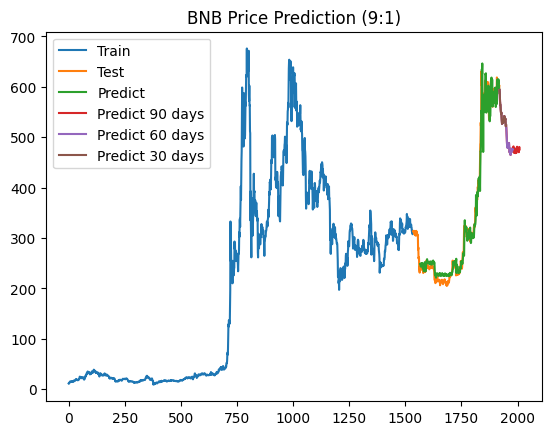

In [121]:
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size + 31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#90 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 90, step=1)
plt.plot(predict_data_index, next_90_days.squeeze(), label="Predict 90 days")

#60 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 60, step=1)
plt.plot(predict_data_index, next_60_days.squeeze(), label="Predict 60 days")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="Predict 30 days")

plt.legend()
plt.title('BNB Price Prediction (9:1)')
plt.show()